# Bahdanau Attention을 이용한 한·영 번역 모델 생성 및 학습 예제

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; 바다나우 어텐션을 이용하여 한국어-영어 번역 모델을 생성하고 이를 평가 하였다. 데이터셋은 박정열(2017)이 제시한 한국어-영어 쌍으로 이루어진 데이터셋을 이용하였으며, 총94,123개의 레코드로 이루어져 있다. 분석 결과, 15,155개의 중복데이터가 존재하고 결측치는 존재하지 않았다. 한, 영 각 언어의 문장의 길이를 공백 기준으로 분석 하였다. 각 언어의 4분위에 해당하는 문장을 중심으로 한국어의 경우 약 31개의 토큰으로 이루어져 있으며, 영어의 경우 약 50개의 토큰으로 이루어져 있다. 데이터 전처리는 '중복 데이터 제거', '언어별 문장 길이 제한', '정규식을 이용한 문장 전처리', '문장 토큰화' 순으로 진행하여 최종 77,223개의 데이터를 모델 학습에 사용하였다. 모델의 경우 GRU 유닛 256개를 사용하였으며 임베딩 사이즈는 256으로 설정 하였다. 학습 옵티마이저는 Adam을 이용하고 배치 사이즈는 64, 학습 회수는 20회로 설정하였다. 최종 손실값은 1.545이다. 8개의 한국어 문장을 바다나우 어텐션 모델에 입력하여 번역 결과를 출력 한 결과, '오바마는 대통령이다.', '나는 고양이다' 등의 한국어 문장이 'obama is member of us.', 'i don't have a lot of the cat.'과 같이 문법에는 문제가 없지만, 입력 문장과 다른 내용의 번역문이 출력 되어, 번역이 올바르지 않게 이루어진 것을 확인 하였다. 이는 학습 데이터가 불충분 한 것이 원인으로 예상 되며, 그럼에도 불구하고 주어와 명사에 대해서 잘 예측하는 것을 확인 하였다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서는 '바다나우 어텐션'을 이용하여 한국어-영어 번역 모델을 생성하고 이를 평가 합니다. 이를 위해 한-영 쌍의 문장으로 구성된 말뭉치 데이터셋을 이용하여, 분석, 전처리 과정을 거쳐 최종적으로 모델을 학습하고 모델의 한국어-영어 번역 성능을 확인합니다. 다음은 예제의 진행 순서를 제시한 것입니다.
</span><br><br>


> _1. 데이터 분석_
>
> _2. 데이터 전처리_
>
> _3. 모델 생성_
>
> _4. 모델 학습 및 평가_


***

#### ___예제 진행에 앞서...___
***
+ 예제에서 사용하는 한국어 형태소 분석기 `Mecab`을 이용하기 위해 미리 설치 하여 줍니다.

> `$ sudo apt-get install g++ openjdk-8-jdk`: jdk 설치
>
> `$ bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)`: curl을 이용한 Mecab 설치
>
> `$ pip install konlpy`: konlpy 설치

<br>

## 2. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 
예제에서는 박정열(2017)이 제시한 한국어-영어 쌍의 데이터셋을 이용 합니다. 총 94,123개의 레코드로 이루어져 있으며, 15,155개의 중복 데이터가 존재하고 결측치는 없었습니다. 각 언어별 문장의 공백 기준 토큰의 개수를 확인 하였습니다. 한국어 데이터의 경우, 문장이 평균 약 14개의 토큰으로 이루어져 있고 4분위 문장의 경우 약 31개의 토큰으로 이루어져 있습니다. 영어 데이터의 경우, 문장이 평균 약 20개의 토큰으로 이루어져 있고 4분위 문장의 경우 약 50개의 토큰으로 이루어져 있습니다.
</span>

***

#### 필요 라이브러리 호출
***
+ 예제에 사용할 라이브러리를 호출 합니다.
***

In [1]:
import re   #정규식
import os   #디렉토리 관리
import io
import random   #학습 데이터 섞기
import tarfile   #gz 압축 풀기
import numpy as np   #행렬 연산
import pandas as pd   #데이터 프레임
from tqdm import tqdm   #학습과정 시각화
import tensorflow as tf   #신경망 연산
from konlpy.tag import Mecab   #형태소 분석


import matplotlib as mpl   #폰트
import matplotlib.pyplot as plt    #데이터 시각화
import matplotlib.ticker as ticker   #틱수
import matplotlib.font_manager as fm   #폰트


fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)
%config InlineBackend.figure_format = 'retina'

<br>

#### 데이터셋 압축 풀기
***
+ 데이터셋 압축파일 `korean-english-park.train.tar.gz`의 압축을 해제하여 줍니다.
***

In [2]:
ap = tarfile.open("./dataset/korean-english-park.train.tar.gz")
ap.extractall("./dataset/")
ap.close()

#### 학습 데이터 출처
***
+ Jungyeul Park, korean-parallel-corpora(2017), https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1
***

<br>

#### 데이터셋 불러오기
***
+ 한국어 문장 데이터와 그 쌍에 해당하는 영어 문장 데이터를 불러옵니다.


+ 한국어 문장과 영어 문장을 한 쌍으로 데이터 프레임을 생성 합니다.
***

In [3]:
path_to_ko = "./dataset/korean-english-park.train.ko"
path_to_en = "./dataset/korean-english-park.train.en"

with open(path_to_ko, "r") as f:
    kor_raw = f.read().splitlines()
    
with open(path_to_en, "r") as f:
    eng_raw = f.read().splitlines()
    
dataset = pd.DataFrame(zip(kor_raw, eng_raw), columns=["kor", "eng"])

<br>

#### 데이터셋 샘플 출력
***
+ 데이터셋 샘플 5개 레코드를 출력 합니다.
***

In [4]:
dataset.sample(5)

,kor,eng
41767,"미국을 방문한 그는 독점 인터뷰에서 ""이란은 법을 지키지 않는다”고 전했다.","""Iran doesn't observe laws,"" she said through ..."
65723,아바나의 칼 마르크스 영화관도 7일 이 영화를 상영했다.,"""Che"" also played Sunday at Havana's Karl Marx..."
54256,경유 1200원대로…,Lee will explain his shift on S...
21038,버렐은 다이애나가 자신에게 칸이 이슬람교도라며 칸과 비공개 결혼식을 올리는 방법을 ...,Burrell said Diana had asked him at one point ...
24867,"그는 ""왕세자비가 흔들리는 눈빛으로 자신을 본 다음 다시 고개를 떨구더니 눈을 감았...",Then she put her head down again and closed he...


<br>

#### 데이터셋 기본 정보 확인
***
+ 94,123개 레코드가 존재하며 15,155개의 중복 데이터, 결측치는 없습니다.
***

In [5]:
dataset.info()

dup = dataset.duplicated()
dup = dup.value_counts()[True]

print(f"Dupliacted Data Num: {dup:,}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94123 entries, 0 to 94122
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   kor     94123 non-null  object
 1   eng     94123 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB
Dupliacted Data Num: 15,155


<br>

#### 데이터 길이 시각화 함수 생성
***
+ 데이터 길이를 시각화 하는 함수를 생성 합니다.
***

In [6]:
#데이터 길이 시각화 함수=========================
def show_sentence_length(sentence_num, title, range_=[0, 500]):
    plt.figure(figsize=(13, 5))
    plt.suptitle(title, fontsize=14)
    
    plt.subplot(1, 2, 1)
    plt.hist(sentence_num, bins=range_[1], range=range_, facecolor='b', label='train')
    plt.xlabel('Number of question')
    plt.ylabel('Count of question')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(sentence_num, labels=['token counts'], showmeans=True)

    plt.show()
    
    print("< Sentence Info >".center(100, "="))
    print(f"길이 최대:    {np.max(sentence_num):4d}")
    print(f"길이 최소:    {np.min(sentence_num):4d}")
    print(f"길이 평균:    {np.mean(sentence_num):7.3f}")
    print(f"길이 표준편차: {np.std(sentence_num):7.3f}", end="\n\n")
    
    percentile25 = np.percentile(sentence_num, 25)
    percentile50 = np.percentile(sentence_num, 50)
    percentile75 = np.percentile(sentence_num, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5
    
    print(f" 25/100분위:  {percentile25:7.3f}")
    print(f" 50/100분위:  {percentile50:7.3f}")
    print(f" 75/100분위:  {percentile75:7.3f}")
    print(f" MAX/100분위: {percentileMAX:7.3f}")
    print(f" IQR: {percentileIQR:7.3f}")
    print("=" * 100)
#End===========================================

<br>

#### 데이터 문장 길이 확인
***
+ 한국어 데이터의 경우, 문장이 평균 약 14개의 단어로 이루어져 있으며, 4분위의 경우 약 31개의 단어로 이루어져 있습니다.

+ 영어 데이터의 경우, 문장이 평균 약 20개의 단어로 이루어져 있으며, 4분위의 경우 약 50개의 단어로 이루어져 있습니다.
***

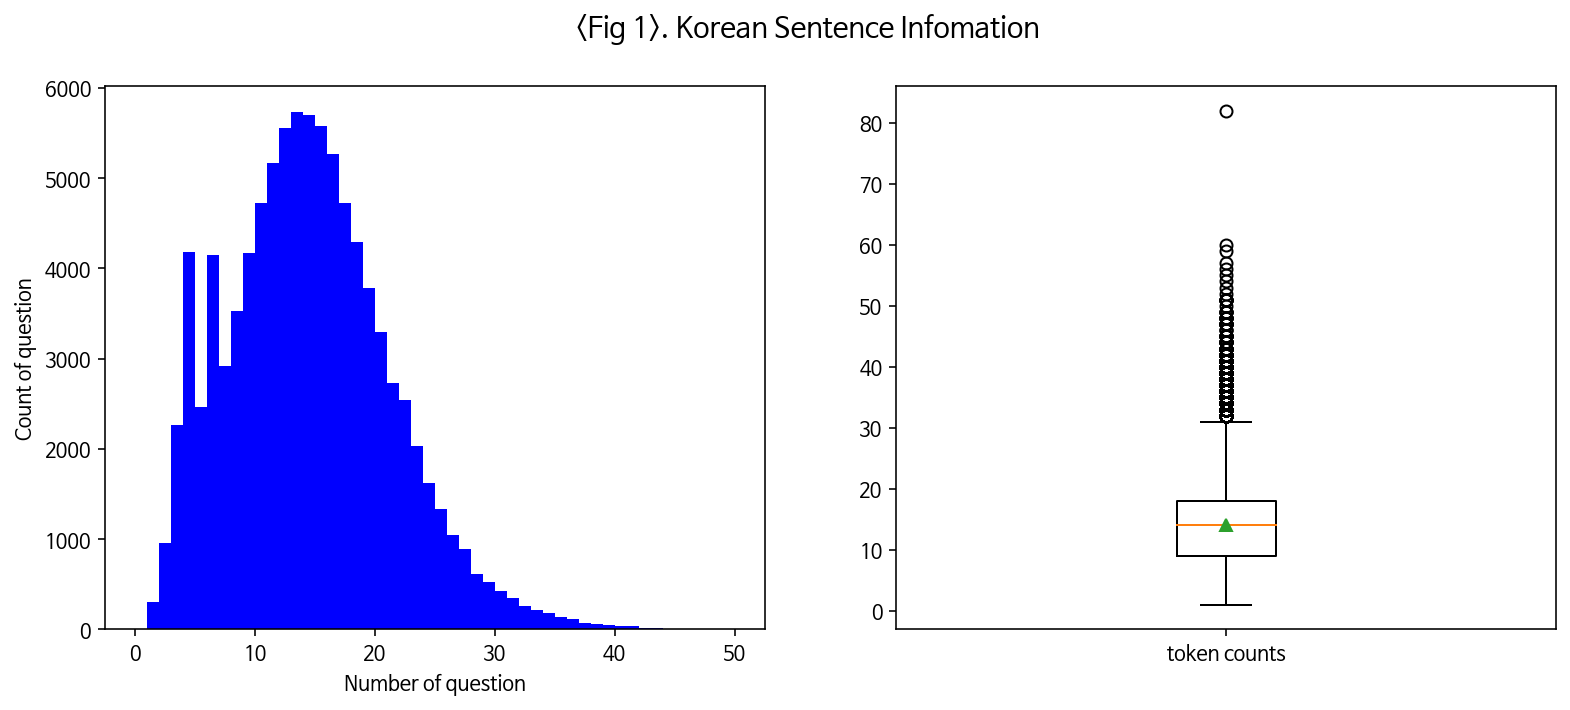

=========================================< Sentence Info >==========================================
길이 최대:      82
길이 최소:       1
길이 평균:     14.047
길이 표준편차:   6.813

 25/100분위:    9.000
 50/100분위:   14.000
 75/100분위:   18.000
 MAX/100분위:  31.500
 IQR:   9.000


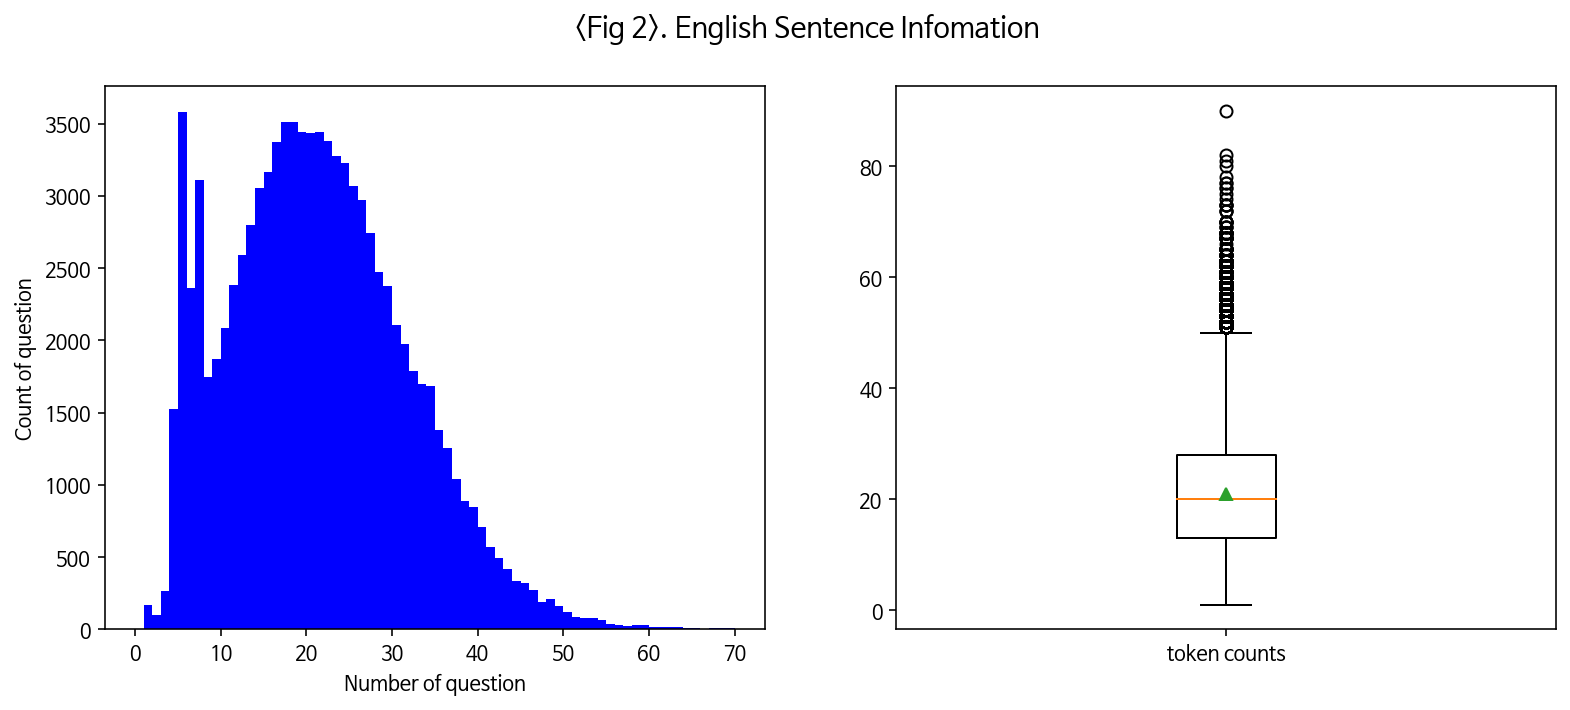

=========================================< Sentence Info >==========================================
길이 최대:      90
길이 최소:       1
길이 평균:     20.897
길이 표준편차:  10.471

 25/100분위:   13.000
 50/100분위:   20.000
 75/100분위:   28.000
 MAX/100분위:  50.500
 IQR:  15.000


In [7]:
kor_counts = [len(text.split()) for text in dataset["kor"]]
eng_counts = [len(text.split()) for text in dataset["eng"]]

show_sentence_length(kor_counts, "<Fig 1>. Korean Sentence Infomation", [0, 50])
show_sentence_length(eng_counts, "<Fig 2>. English Sentence Infomation", [0, 70])

<br>

## 3. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 수행한 데이터 분석을 바탕으로 전처리를 수행 합니다. 전처리 수행 과정은 '중복 데이터 제거', '언어별 문장 길이 제한',
'정규식을 이용한 문장 전처리', '문장 토큰화' 순으로 진행하였습니다. 우선, 15,155개의 중복 데이터를 제거하고 한국어의 경우 31개 초과 토큰으로 구성된 문장과 영어의 경우 50개 초과 토큰으로 구성된 문장을 제외하여 줍니다. 정규식을 이용하여 특수문자 제거 및 공백 추가를 시행하고
디코더에 입력될 언어인 영어의 경우에는 &lt;sos>, &lt;eos> 토큰을 문장의 앞과 뒤에 추가하여 줍니다. 한국어의 경우 Mecab 형태소 분석기를 위용하여 토큰화를 진행하고 영어의 경우 공백을 기준으로 토큰화를 진행합니다. 단어사전의 크기는 한국어의 경우 4분위에 해당하는 토큰이 18회 사용되는 것을 근거로 18회 이하로 사용된 토큰 42,627개를 이용 합니다. 영어의 경우 4분위에 해당하는 토큰이 21회 사용된 것을 근거로 21회 이하로 사용된 토큰 37,591개를 이용 합니다. 최종 77,223개의 한-영 데이터 쌍을 획득 합니다.
</span>

***

#### 중복 데이터 제거
***
+ 중복 데이터를 제거하여 78,968개의 데이터를 획득 합니다.
***

In [8]:
print("Before Data Num:", len(dataset))
dataset.drop_duplicates(inplace=True)
print("After Data Num:", len(dataset))

Before Data Num: 94123
After Data Num: 78968


<br>

#### 문장 길이 기준 데이터 필터링
***
+ 문장 길이를 설정하고 해당 길이 이상의 문장은 제외 하여 줍니다.


+ 한국어의 경우 31개 초과의 단어로 이루어진 문장을, 영어의 경우 50개 초과의 단어로 이루어진 문장을 제외 합니다.
***

In [9]:
def filt_sentence_length(df, col, sentence_len):
    df = df.copy()
    df["len"] = df[col].apply(lambda x: len(x.split()))
    df = df.loc[df["len"] < sentence_len]
    df.drop(["len"], axis="columns", inplace=True)
    return df
    
dataset = filt_sentence_length(dataset, "kor", 31)
dataset = filt_sentence_length(dataset, "eng", 50)

<br>

#### 정규식을 이용한 문장 전처리
***
+ 정규식을 이용하여 특수문자 제거 및 공백 추가를 시행 합니다.


+ 영어의 경우 디코더에 입력되므로 `<sos>`, `<eos>` 토큰을 문장의 앞, 뒤에 추가 하여 줍니다.
***

In [10]:
#전처리 함수===========================
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([0-9?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence
#End===================================


#전처리 함수 v2========================
def preprocess_with_token(sentence, decoder_data=False):
    sentence = preprocess_sentence(sentence)
                                   
    if decoder_data:   #decoder
        sentence = "<sos> " + sentence + " <eos>"
    return sentence
#End===================================


dataset["kor"] = dataset["kor"].apply(preprocess_sentence)
dataset["eng"] = dataset["eng"].apply(lambda x: preprocess_with_token(x, True))

dataset.sample(5)

,kor,eng
29958,지난 1 9 7 9 년 대회는 섭씨 2 8 도의 더위 속에 진행됐다 .,<sos> the chicago race was run in record tempe...
77001,청와대에 의하면 추 장관과 이백만 청와대 홍보수석은 아침 일찍 노 대통령에게 사표를...,"<sos> the minister and lee baek man , senior p..."
462,난 롱 죤 액티브라구 .,<sos> i m long john active . <eos>
38186,이스라엘은 지난해 총선에서 하마스가 팔레스타인 자치정부를 장악하자 팔레스타인측 세수...,<sos> all those funds were withheld after hama...
15992,미군과 이라크 내무부 발표가 같은 사건에 대한 보고인지는 아직 확실치 않다 .,<sos> it is not clear if the u . s . and iraqi...


<br>

#### 문장 토큰화 함수 생성
***
+ seq2seq 모델에 입력할 한국어 데이터와 영어 데이터를 토큰화를 위한 함수를 생성 합니다.
***

In [11]:
def tokenize(corpus, vocab_size, maxlen, encoder_TF=True):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='',
        oov_token="<UNK>",
        num_words=vocab_size
    )
    corpus_input = corpus
    
    if encoder_TF:   #encoder data는 '한국어'이므로 mecab 형태소 분석
        m = Mecab()
    
        corpus_input = []
        for sentence in corpus:
            corpus_input.append(m.morphs(sentence))
    
    tokenizer.fit_on_texts(corpus_input)
    
    if vocab_size is not None:
        words_frequency = [w for w,c in tokenizer.word_index.items() if c >= vocab_size + 1]
        for w in words_frequency:
            del tokenizer.word_index[w]
            del tokenizer.word_counts[w]
    
    tensor = tokenizer.texts_to_sequences(corpus_input)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor,
        padding='post',
        maxlen=maxlen
    )
    return tensor, tokenizer

<br>

#### 문장 토큰화 진행
***
+ seq2seq 모델에 입력할 한국어 데이터와 영어 데이터를 토큰화 합니다.


+ 한국어의 경우 인코더에 입력되며, `Mecab`을 이용하여 형태소 단위로 토큰화를 진행 합니다.


+ 영어의 경우 디코더에 입력되며, 공백을 단위로 토큰화를 진행 합니다.


+ 해당 토큰화는 좀 더 구체적인 분석을 위해 진행하는 것이므로, 모든 단어를 사용하고 패딩의 경우 최대 길이로 설정 합니다.


+ 한국어의 경우 49,702개의 토큰이, 영어의 경우 43,830개의 토큰이 생성 되었습니다.
***

In [12]:
enc_tensor, enc_tokenizer = tokenize(dataset["kor"], None, None, encoder_TF=True)
dec_tensor, dec_tokenizer = tokenize(dataset["eng"], None, None, encoder_TF=False)

print("Korean Vocab Size:", f"{len(enc_tokenizer.word_index):,}")
print("English Vocab Size:", f"{len(dec_tokenizer.word_index):,}")

Korean Vocab Size: 49,702
English Vocab Size: 43,830


<br>

#### 토큰별 사용 빈도 확인
***
+ 추후 단어사전 크기를 설정하기 위해, 한국어와 영어 토큰별 사용 빈도를 확인 합니다.


+ 한국어의 경우 토큰은 평균 약 46회 사용 되었고 4분위의 토큰은 약 18회 사용 되었습니다.


+ 영어의 경우 토큰은 평균 약 48회 사용 되었고 4분위의 토큰은 약 21회 사용 되었습니다.
***

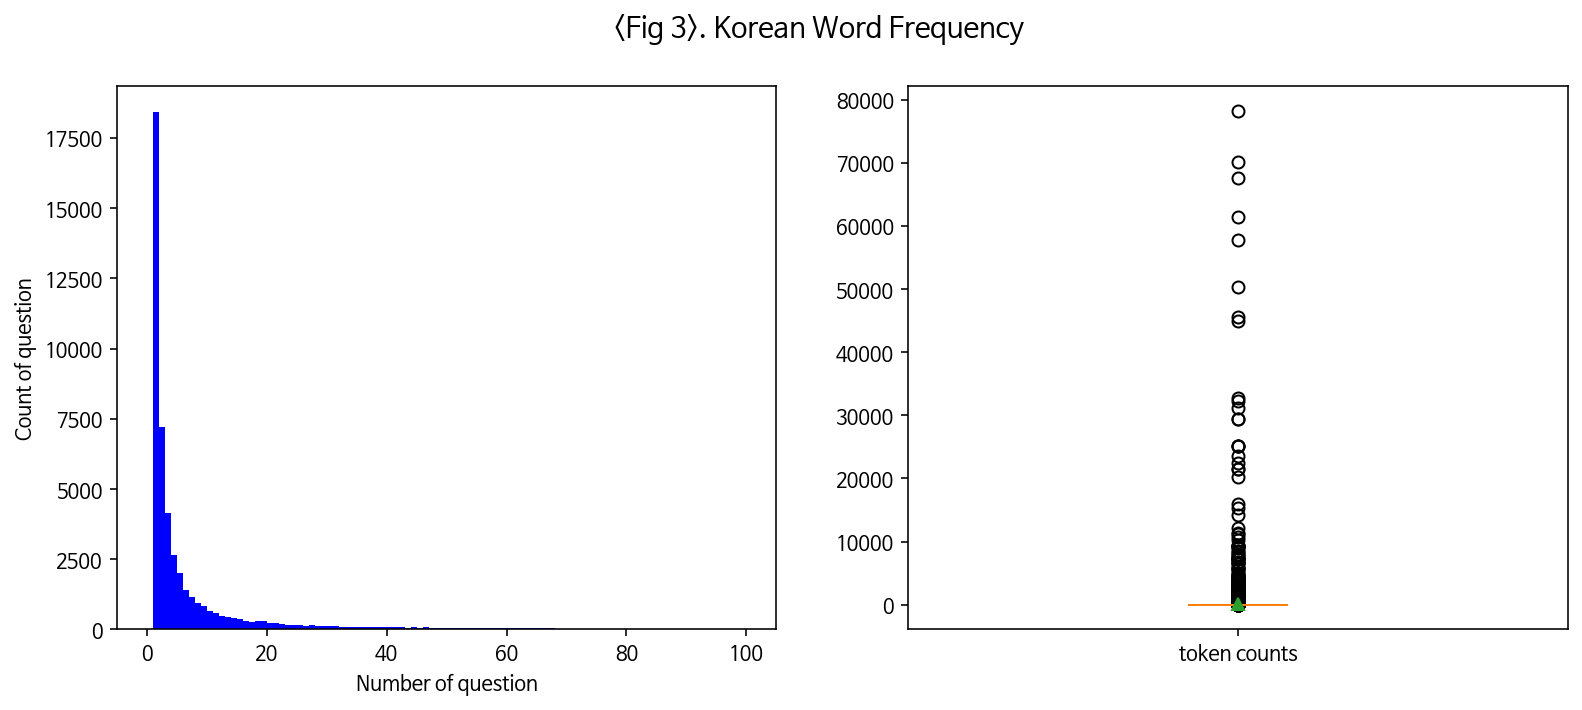

=========================================< Sentence Info >==========================================
길이 최대:    78266
길이 최소:       1
길이 평균:     46.053
길이 표준편차: 920.852

 25/100분위:    1.000
 50/100분위:    2.000
 75/100분위:    8.000
 MAX/100분위:  18.500
 IQR:   7.000


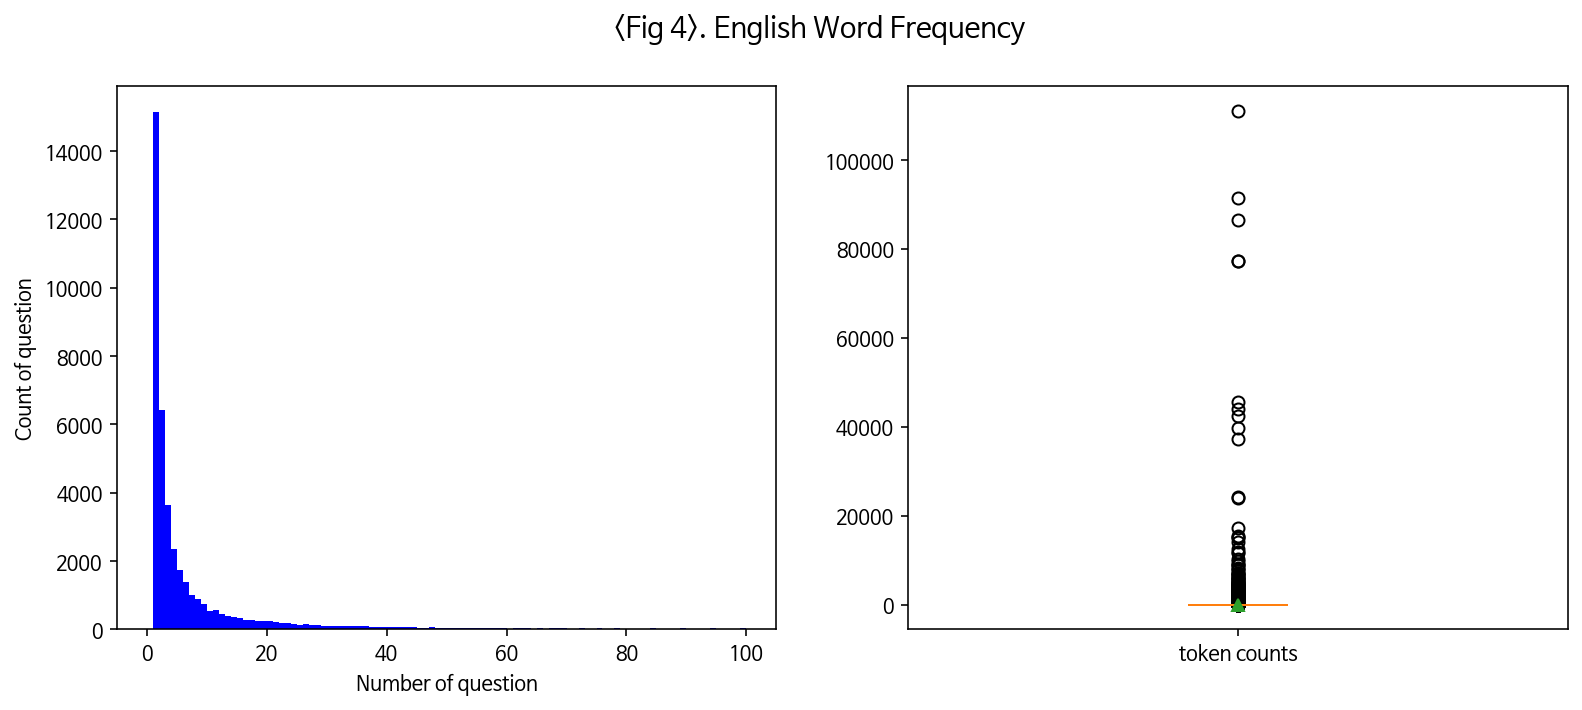

=========================================< Sentence Info >==========================================
길이 최대:    111106
길이 최소:       1
길이 평균:     48.212
길이 표준편차: 1107.312

 25/100분위:    1.000
 50/100분위:    3.000
 75/100분위:    9.000
 MAX/100분위:  21.000
 IQR:   8.000


In [13]:
enc_freq = [value for value in enc_tokenizer.word_counts.values()]
dec_freq = [value for value in dec_tokenizer.word_counts.values()]

show_sentence_length(enc_freq, "<Fig 3>. Korean Word Frequency", [0, 100])
show_sentence_length(dec_freq, "<Fig 4>. English Word Frequency", [0, 100])

<br>

#### 토큰별 사용 빈도 상세 확인
***
+ 앞서 확인한 언어별 4분위에 해당하는 토큰의 수를 확인 합니다.


+ 한국어의 경우 18회 이하로 사용된 토큰은 총 42,627개 입니다.


+ 영어의 경우 21회 이하로 사용된 토큰은 총 37,591개 입니다.
***

In [14]:
def wordNumByFreq(tokenizer, freq_num):
    sorted_freq = sorted(tokenizer.word_counts.items(), key=lambda x: x[1])
    for idx, (_, freq) in enumerate(sorted_freq):
        if freq > freq_num: break;
    return idx


print(f"Korean Words Used Under {18}: {wordNumByFreq(enc_tokenizer, 18):,}")
print(f"English Words Used Under {21}: {wordNumByFreq(dec_tokenizer, 21):,}")

Korean Words Used Under 18: 42,516
English Words Used Under 21: 37,506


<br>

#### 최종 토큰화 진행
***
+ 앞서 확인한 정보를 통해, 토큰화를 진행 합니다.


+ 단어 사전의 크기는 한국어의 경우 42,516개로 설정 하고, 영어의 경우 37,506개로 설정 합니다.


+ 최종 데이터는 총 77,223개 입니다.
***

In [15]:
enc_tensor, enc_tokenizer = tokenize(dataset["kor"], 42516, None, encoder_TF=True)
dec_tensor, dec_tokenizer = tokenize(dataset["eng"], 37506, None, encoder_TF=False)

print("Dataset num:", len(enc_tensor))

Dataset num: 77223


<br>

## 4. 모델 설계 및 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서는 바다나우 어텐션 모델을 이용 합니다. RNN 레이어로 GRU 유닛을 이용 합니다. 또한 유닛의 크기는 256으로 설정하고 과적합을 방지하기 위해 0.2 비율로 드롭아웃을 시행 합니다. 임베딩 사이즈는 256으로 설정 합니다. 학습 옵티마이저는 Adam을 이용하고배치 사이즈는 64, 학습 회수는 20회로 설정하여 학습을 진행 하였습니다. 최종 손실값은 1.545 입니다.
</span>

***

#### 모델 설계
***
+ 본 예제에서 사용하는 attention seq2seq 모델은 '바다나우 attention' 입니다.


+ 유닛의 크기 256, 임베딩 벡터 크기 256으로 설정하여 모델을 생성 합니다.
***

In [16]:
#Attention=================================================
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn
#End=======================================================


#인코더====================================================
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            enc_units,
            dropout=0.2,
            return_sequences=True
        )
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out
#End=======================================================


#디코더====================================================
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            dec_units,
            dropout=0.2,
            return_sequences=True,
            return_state=True
        )
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn
#End=======================================================


SRC_VOCAB_SIZE = len(enc_tokenizer.word_index) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.word_index) + 1

units = 256
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

<br>

#### 학습 하이퍼파리미터 설정
***
+ 학습 옵티마이저와 손실 함수를 설정 합니다.


+ 옵티마이저는 'Adam'을 사용 합니다.
***

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

<br>

#### 모델 학습
***
+ 모델을 학습 합니다.


+ 배치 사이즈는 64, 학습 회수는 20회로 설정하여 학습을 진행 합니다.


+ 최종 손실값은 1.545 입니다.
***

In [18]:
#손실 함수====================================
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)
#End==========================================


#학습 함수====================================
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<sos>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss
#End==========================================


EPOCHS = 20
BATCH_SIZE = 64


for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 20: 100%|██████████| 1207/1207 [10:57<00:00,  1.84it/s, Loss 1.5446]


<br>

## 5. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 학습된 모델에 한국어 문장을 입력하여 모델이 출력한 번역 결과를 확인 합니다. 변역 문장과 함께 Attention Matrix를 시각화하여 문장이 올바르게 학습 되었는지 확인 합니다. '오바마는 대통령이다.', '커피는 필요 없다.', '일곱 명의 사망자가 발생했다.' 등의 총 8개의 문장을 입력하였으며, 그에 대한 결과로 'obama is a member of us.', 'the coffee is to be', 'seven people were killed.' 등의 변역 결과가 출력 된 것을 확인 하였습니다.
</span>

***

#### 모델 평가를 위한 함수 생성
***
+ 한국어를 영어로 번역하는 함수 및 Attention Mmatrix 시각화 함수를 생성 합니다.
***

In [19]:
#한국어 ===> 영어 번역 함수=====================
def evaluate(sentence, encoder, decoder):
    m = Mecab()
    
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    sentence = m.morphs(sentence)
    
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(
        inputs,
        maxlen=enc_tensor.shape[-1],
        padding='post'
    )

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<sos>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<eos>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention
#End============================================


#Matrix 생성 함수===============================
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
#End============================================


#번역 및 시각화 함수============================
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))
#End============================================

<br>

#### 모델 평가를 위한 번역 실시
***
+ `오바마는 대통령이다.`, `시민들은 도시 속에 산다.`, `커피는 필요 없다.`, `일곱 명의 사망자가 발생했다.` 문장을 모델에 입력하여 영어로 번역되는 결과를 확인 합니다.
***

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is a member of us . <eos> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator


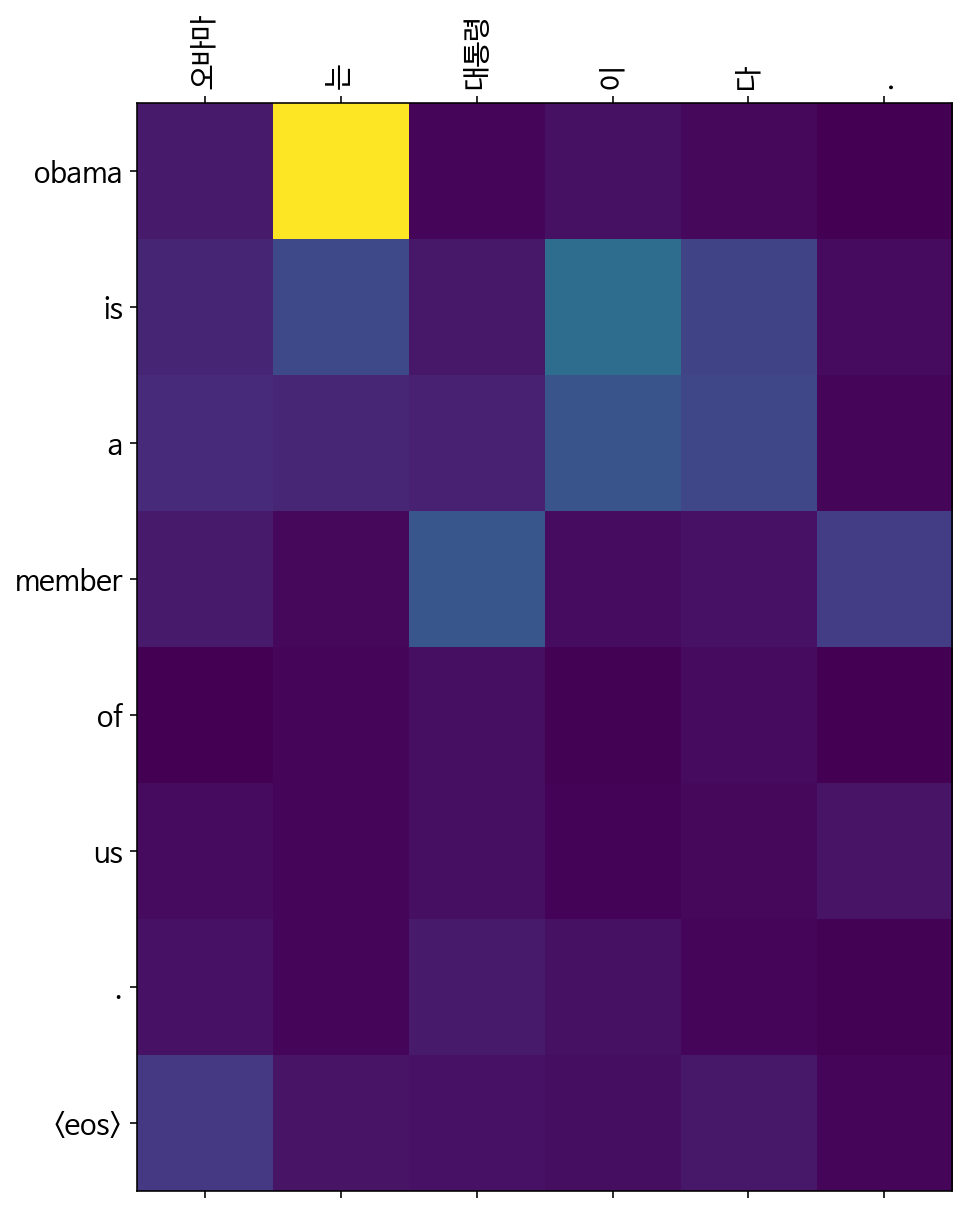



Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the city of the city of the city . <eos> 


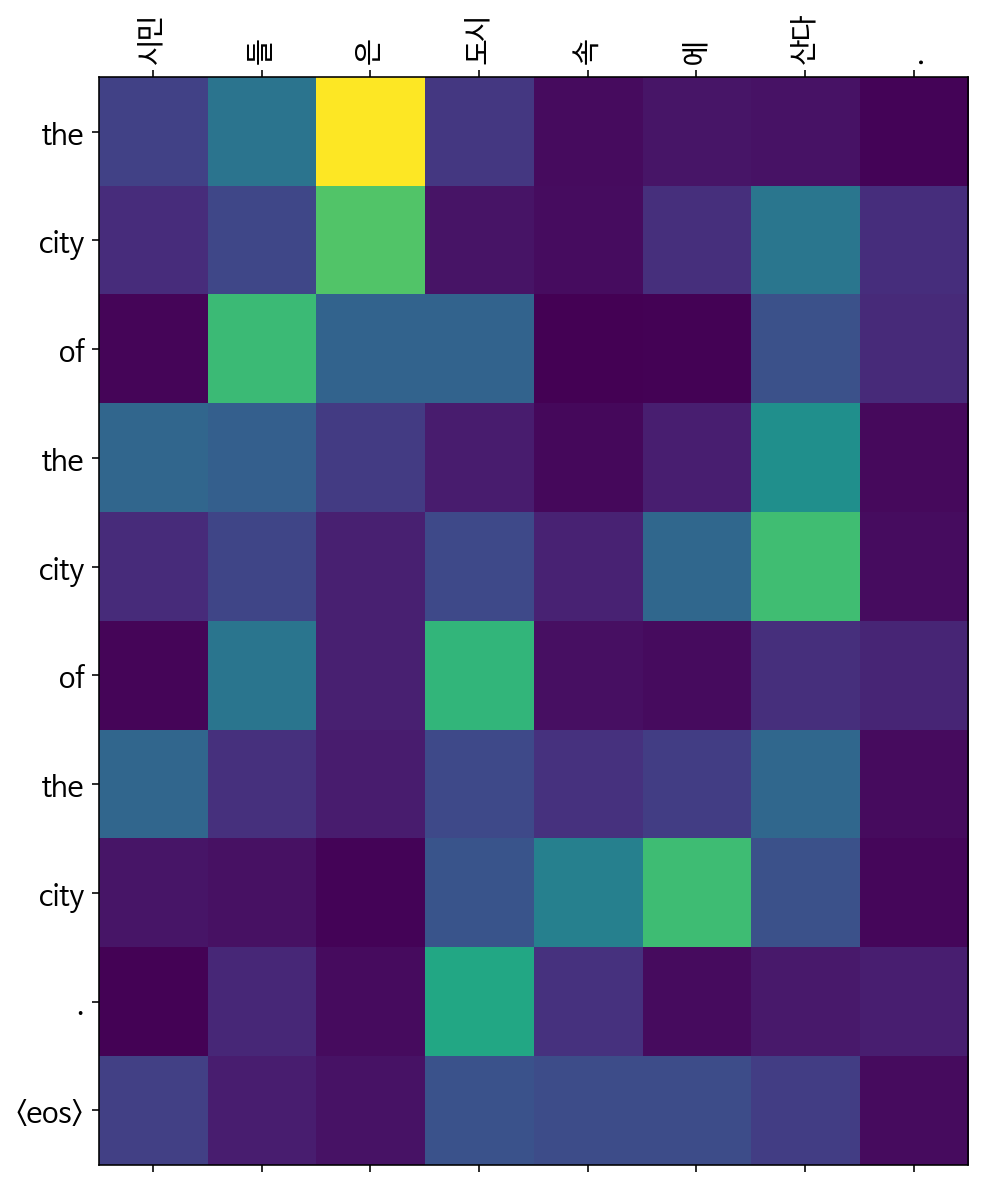



Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the coffee is to be <eos> 


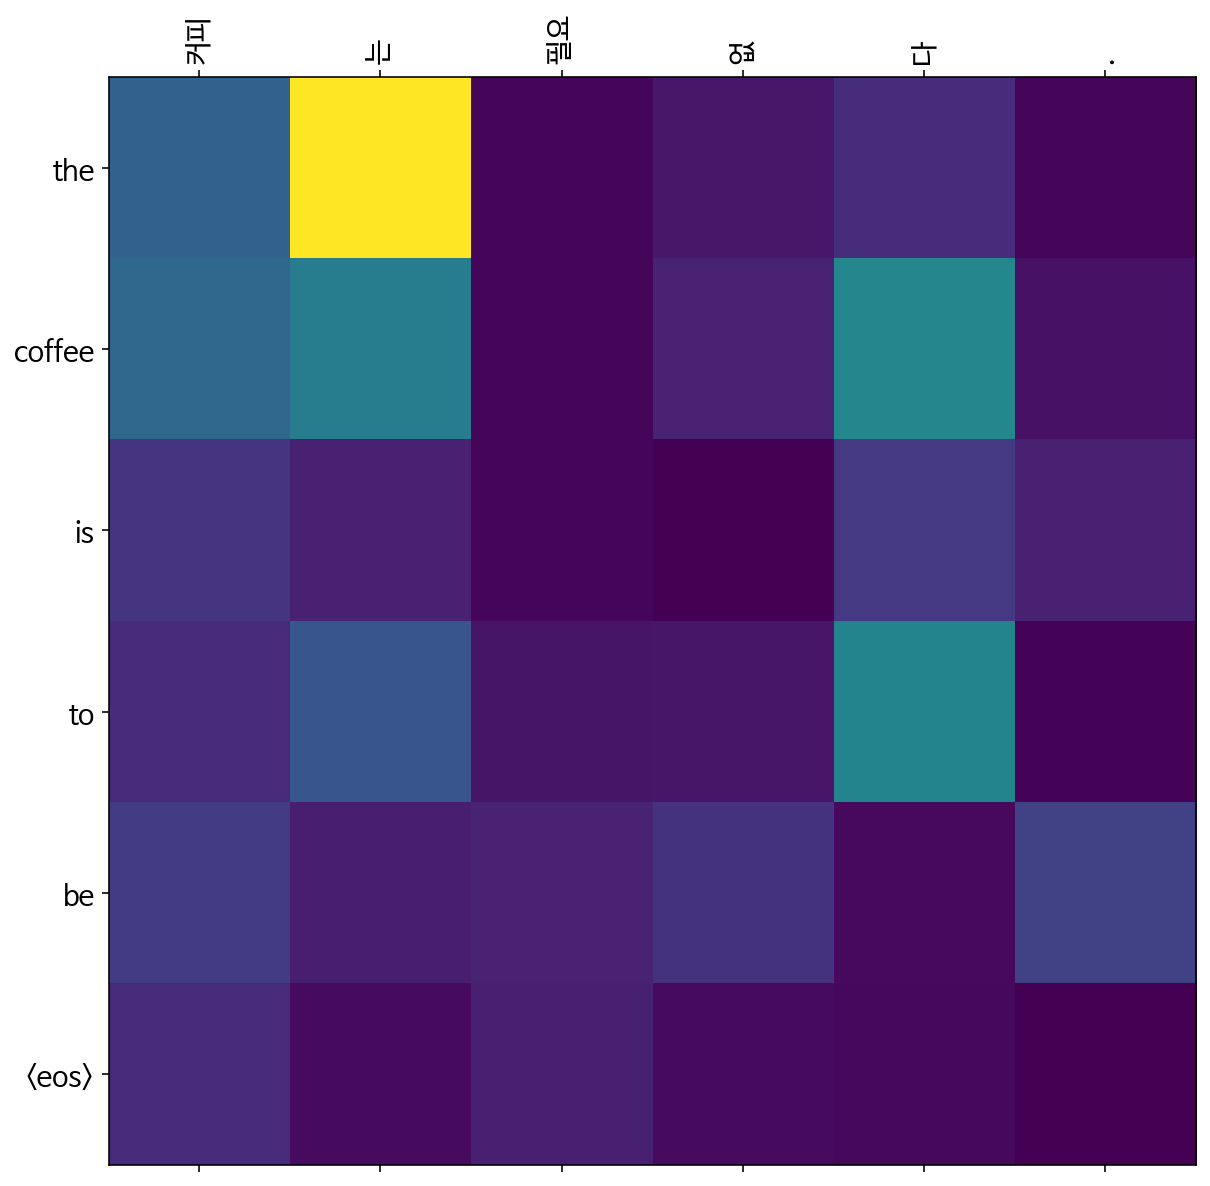



Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven people were killed . <eos> 


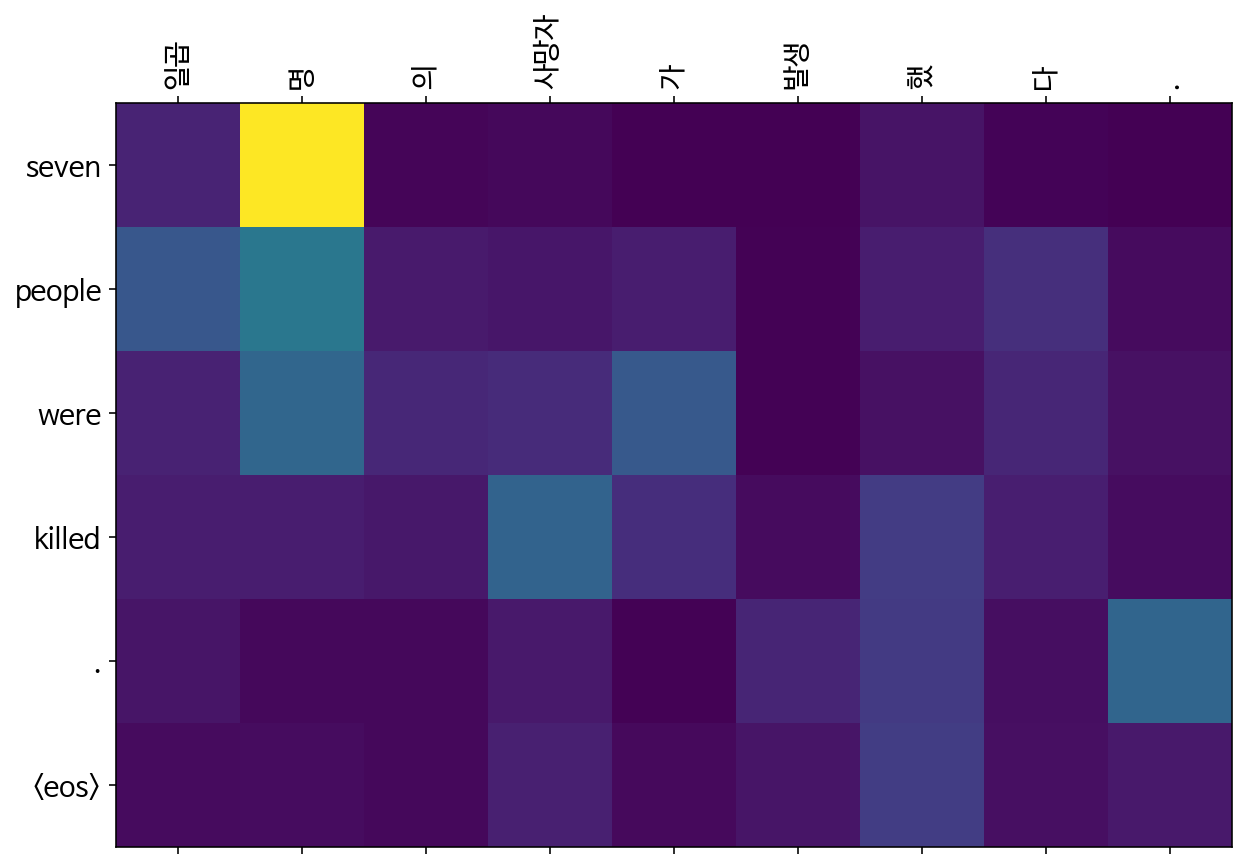

In [20]:
translate("오바마는 대통령이다.", encoder, decoder)
print("=" * 100, end="\n\n\n")

translate("시민들은 도시 속에 산다.", encoder, decoder)
print("=" * 100, end="\n\n\n")

translate("커피는 필요 없다.", encoder, decoder)
print("=" * 100, end="\n\n\n")

translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

<br>

#### 모델 평가를 위한 번역 실시2
***
+ `나는 고양이다.`, `아버지가 방에 들어가신다.`, `아버지 가방에 들어가신다.`, `오늘은 크리스마스다.` 문장을 모델에 입력하여 영어로 번역되는 결과를 확인 합니다.
***

Input: ['나', '는', '고양이', '다', '.']
Predicted translation: i don t have a lot of the cat . <eos> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator


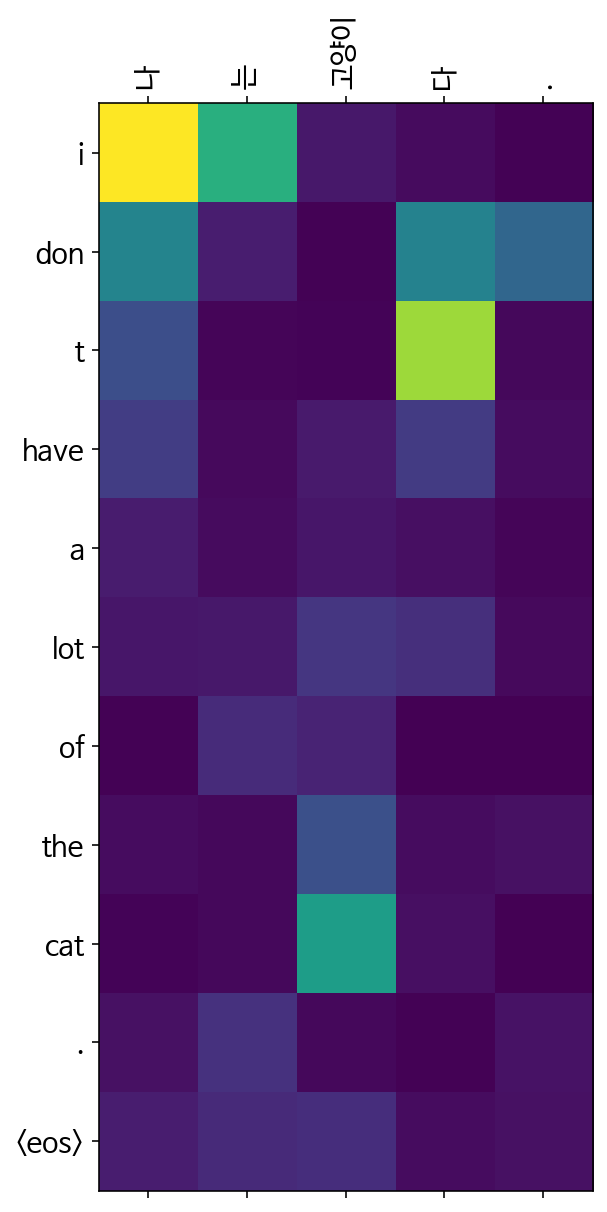



Input: ['아버지', '가', '방', '에', '들어가', '신다', '.']
Predicted translation: the father was a . <eos> 


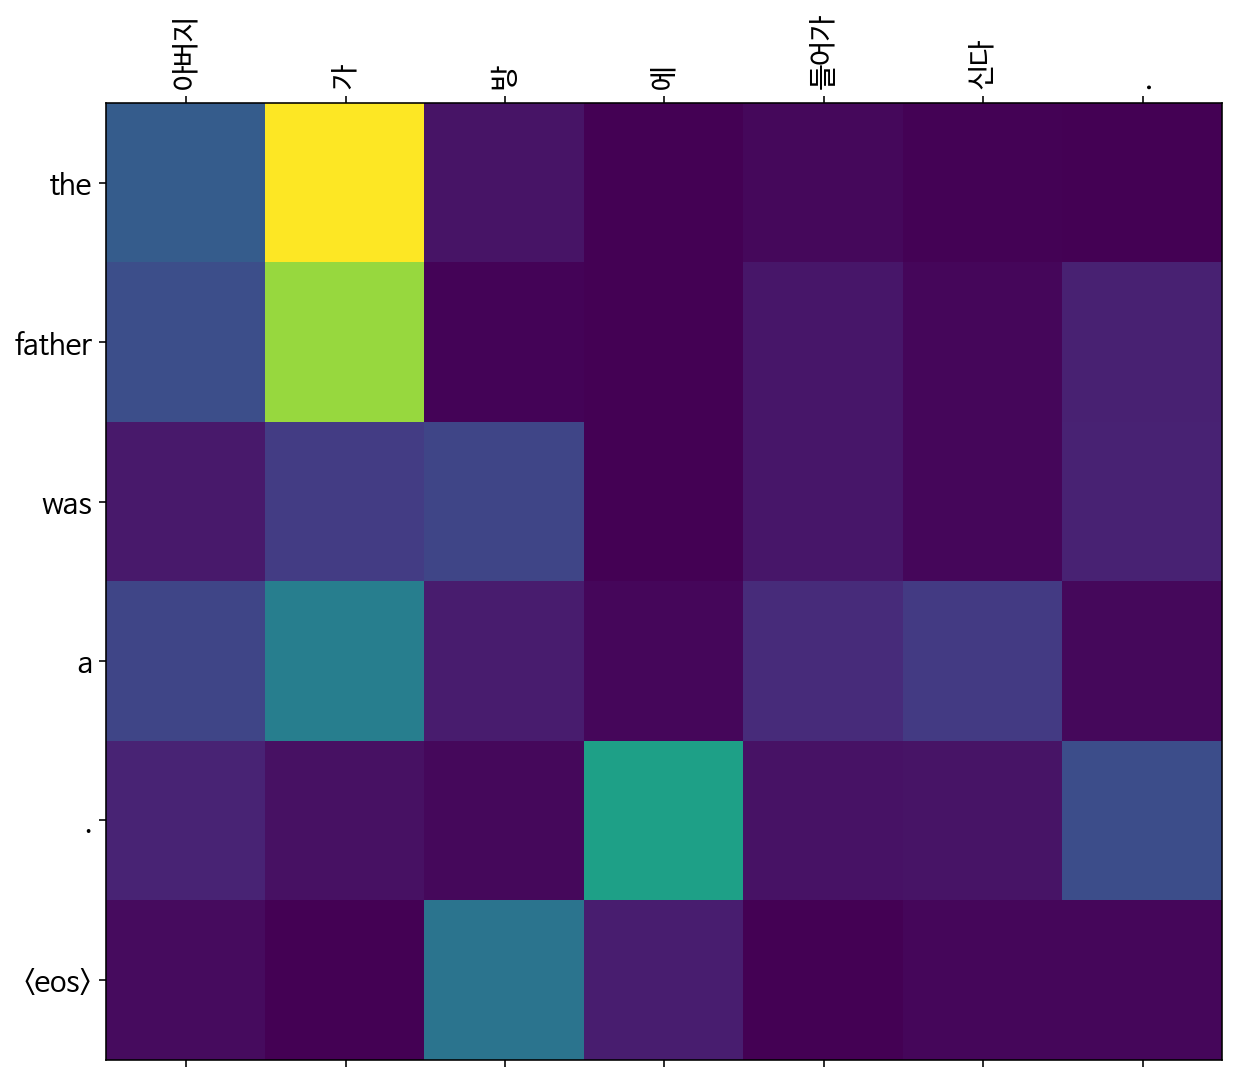



Input: ['아버지', '가방', '에', '들어가', '신다', '.']
Predicted translation: the boy s father s <eos> 


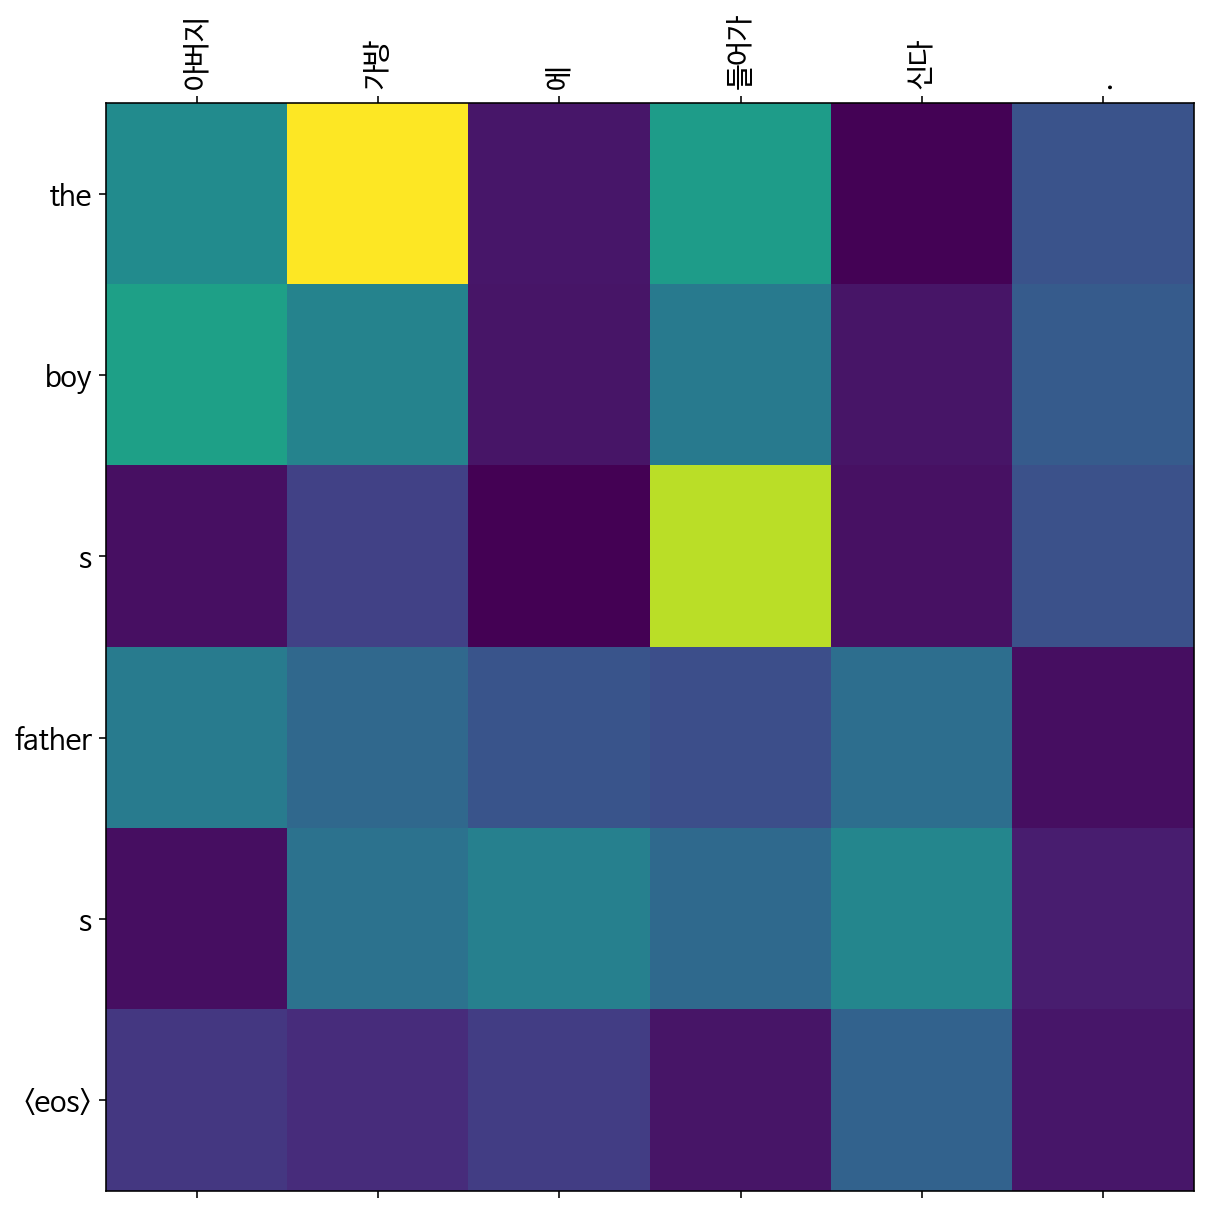



Input: ['오늘', '은', '크리스마스', '다', '.']
Predicted translation: today is a day <eos> 


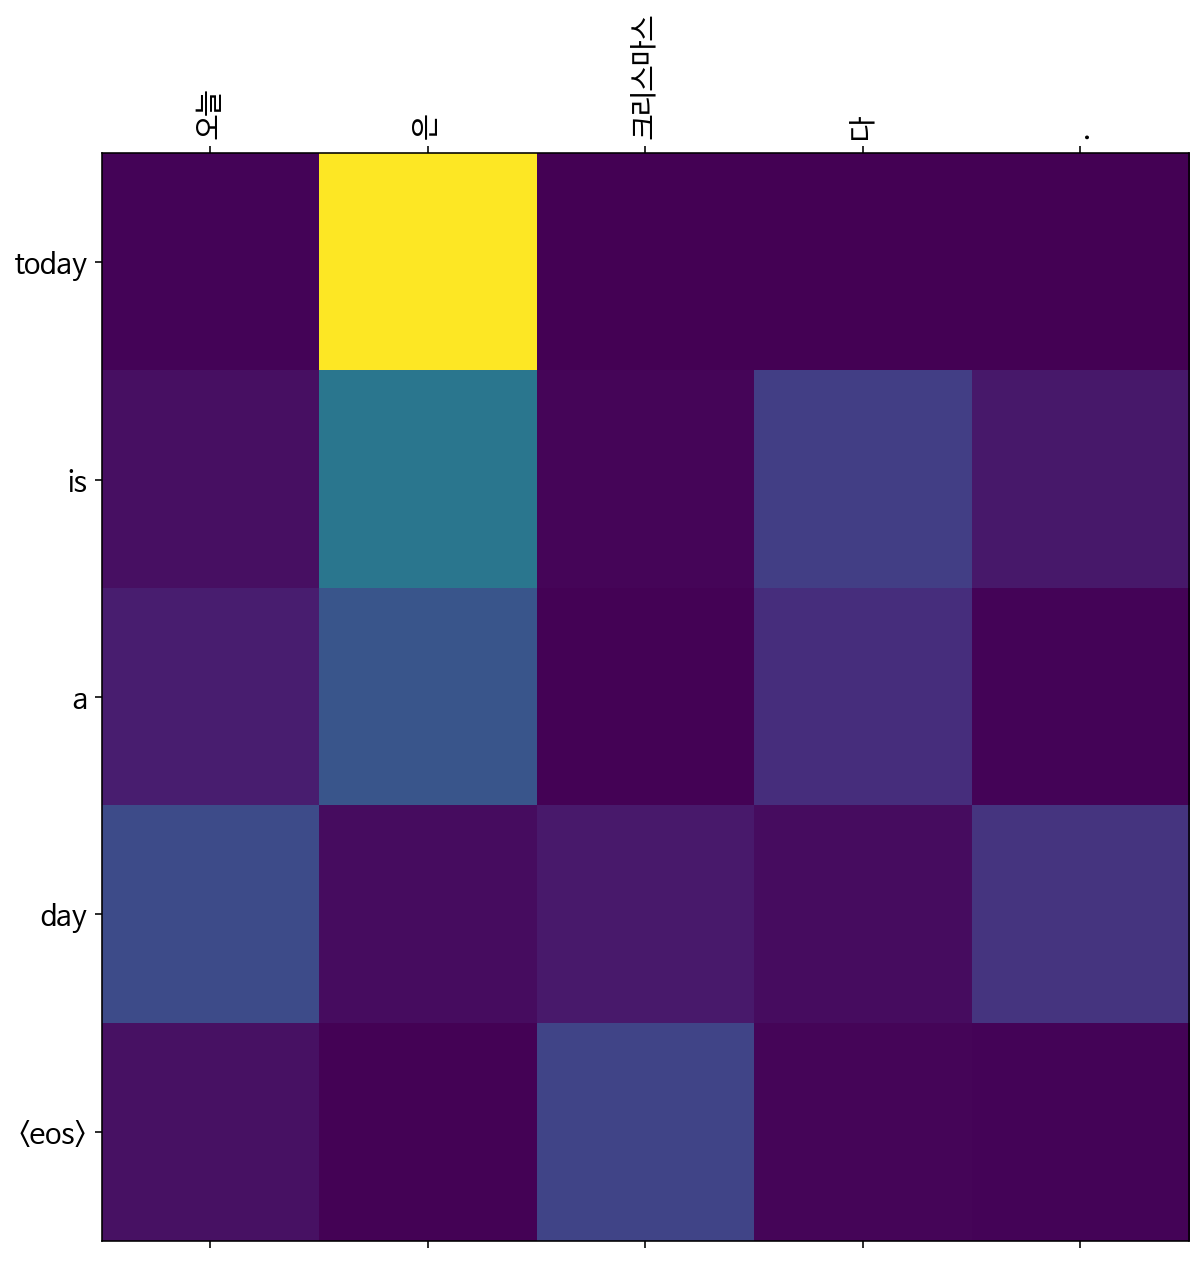

In [23]:
translate("나는 고양이다.", encoder, decoder)
print("=" * 100, end="\n\n\n")

translate("아버지가 방에 들어가신다.", encoder, decoder)
print("=" * 100, end="\n\n\n")

translate("아버지 가방에 들어가신다.", encoder, decoder)
print("=" * 100, end="\n\n\n")

translate("오늘은 크리스마스다.", encoder, decoder)
print("=" * 100, end="\n\n\n")

<br>

## 6. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 한국어-영어 데이터셋을 이용하여 바다나우 어텐션 모델을 학습하고 모델의 번역 결과를 출력하여 보았습니다. 그 결과, '오바마는 대통령이다.', '나는 고양이다' 등의 한국어 문장을 'obama is member of us.', 'i don't have a lot of the cat.'과 같이 번역이 올바르지 않게 이루어진 것을 확인 하였습니다. 이는 학습에 사용된 데이터가 77,223개로 불충분한 것이 원인으로 예상 됩니다. 그럼에도 불구하고 '오바마'를 'obama'로 '커피'는 'the coffee', '일곱 명'은 'seven people' 등으로 주어에 대해 상당히 정확하게 예측 하였습니다. [표 1]은 바다나우 어텐션 모델의 한국어-영어 번역 결과를 제시한 것입니다.
</span><br><br>


|한국어 문장|영어 번역 결과|
|:--------:|:--------:|
|오바마는 대통령이다.|obama is a member of us.|
|시민들은 도시 속에 산다.|the city of the city of the city.|
|커피는 필요 없다.|the coffee is to be|
|일곱 명의 사망자가 발생했다.|seven people were killed.|
|나는 고양이다.|i don t have a lot of the cat.|
|아버지가 방에 들어가신다.|the father was a.|
|아버지 가방에 들어가신다.|the boy s father s|
|오늘은 크리스마스다.|today is a day|

[표 1] 바다나우 어텐션 모델의 한국어-영어 번역 결과

***

### _Going Deeper 10_
***
_……다음 예제인 [[Going Deeper 10]](https://nbviewer.org/github/YAGI0423/aiffel_going_deeper/blob/main/going_deeper_10/GD10_v4_1.ipynb)에서는 'Transformer를 이용한 한-영 번역 모델 생성 및 학습'을 다룹니다. 따라서 [Going Deeper 10]의 내용은 본 예제의 연장선 입니다. [Going Deeper 10]에서는 동일한 데이터셋을 이용하여 본 에제의 `Bahdanau Attention`과 `Transformer`의 번역 결과를 비교할 것입니다._
***

#### 형상관리 기록
***
+ v1_1: 실습 예제 진행


+ v1_2: 제출 예제 진행


+ v2_1: 문장 길이 및 단어 사전 크기 설정


+ v3_1: 모델 설정


+ v4_1: 'Going Deeper 10'과 연결
***